In [1]:
# single

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 200,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 800
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)

Checkpoint 100, Accuracy: 0.8888888888888888, Loss: 0.3564668231540256
Checkpoint 200, Accuracy: 0.9506172839506173, Loss: 0.3886554506089952
Checkpoint 300, Accuracy: 0.9506172839506173, Loss: 0.3886554506089952
Checkpoint 400, Accuracy: 0.9506172839506173, Loss: 0.3886554506089952
Checkpoint 500, Accuracy: 0.9506172839506173, Loss: 0.3886554506089952
Checkpoint 600, Accuracy: 0.9506172839506173, Loss: 0.3886554506089952
Checkpoint 700, Accuracy: 0.9506172839506173, Loss: 0.3886554506089952
Checkpoint 800, Accuracy: 0.9506172839506173, Loss: 0.3886554506089952


In [10]:
print(history)

[{'accuracy': 0.8255451713395638, 'mean_square_error': 2.999958032462471, 'categorical_crossentropy': 0.6985641907308703, 'precision': 0.7383177570093458, 'recall': 0.7383177570093458, 'f1': 0.7383177570093457, 'essential_metrics': {0: {'tp_hit': 70, 'fp_hit': 16, 'tn_hit': 17, 'fn_hit': 4}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 89, 'fn_hit': 18}, 2: {'tp_hit': 9, 'fp_hit': 12, 'tn_hit': 80, 'fn_hit': 6}}}, {'accuracy': 0.8940809968847352, 'mean_square_error': 0.24479870061703984, 'categorical_crossentropy': 0.39160313116055784, 'precision': 0.8411214953271028, 'recall': 0.8411214953271028, 'f1': 0.8411214953271028, 'essential_metrics': {0: {'tp_hit': 69, 'fp_hit': 12, 'tn_hit': 21, 'fn_hit': 5}, 1: {'tp_hit': 17, 'fp_hit': 5, 'tn_hit': 84, 'fn_hit': 1}, 2: {'tp_hit': 4, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 11}}}, {'accuracy': 0.8940809968847352, 'mean_square_error': 0.24479870061703984, 'categorical_crossentropy': 0.39160313116055784, 'precision': 0.8411214953271028, 'recall': 0.841

In [11]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

In [12]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [13]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.74234384 0.24003546 0.01762071]
[1. 0. 0.] <-> [0.45919922 0.10989369 0.43090704]
[1. 0. 0.] <-> [0.90575594 0.06117143 0.0330726 ]
[1. 0. 0.] <-> [0.8855137  0.06815753 0.04632868]
[1. 0. 0.] <-> [0.7649592  0.10292758 0.13211319]
[1. 0. 0.] <-> [0.68421435 0.1147425  0.20104323]
[1. 0. 0.] <-> [0.70326513 0.10015799 0.19657685]
[1. 0. 0.] <-> [0.8945048  0.06551168 0.03998354]
[1. 0. 0.] <-> [0.8784721  0.09371099 0.02781692]
[1. 0. 0.] <-> [0.48059237 0.11895569 0.400452  ]
[1. 0. 0.] <-> [0.8756691  0.09760977 0.02672113]
[1. 0. 0.] <-> [0.48222497 0.11435566 0.40341935]
[0. 0. 1.] <-> [0.32057235 0.10639353 0.5730341 ]
[1. 0. 0.] <-> [0.896045   0.07022652 0.03372839]
[1. 0. 0.] <-> [0.9039237  0.04978098 0.04629533]
[1. 0. 0.] <-> [0.8834514  0.06848262 0.04806599]
[0. 1. 0.] <-> [0.18460041 0.81285983 0.00253978]
[0. 1. 0.] <-> [0.21175316 0.7857244  0.00252251]
[1. 0. 0.] <-> [0.8716625  0.10218234 0.02615519]
[1. 0. 0.] <-> [0.8805843  0.05750363 0.06191204]


In [14]:
# Testing Performance

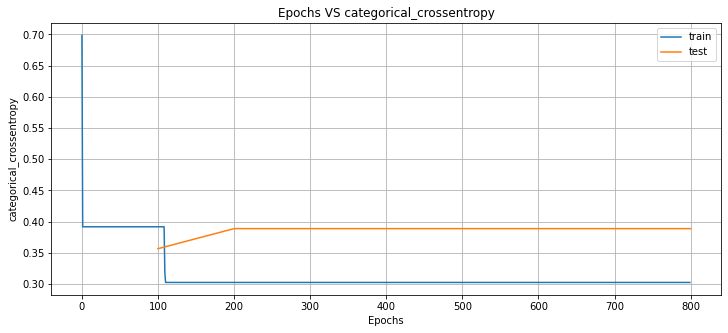

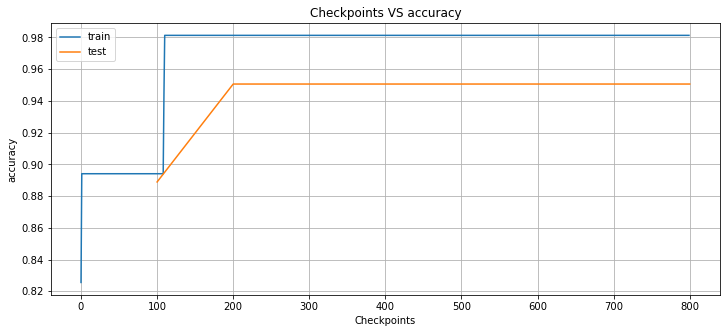

In [15]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [16]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8888888888888888, 'mean_square_error': 0.22821465498204502, 'categorical_crossentropy': 0.3564668231540256, 'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'f1': 0.8333333333333334, 'essential_metrics': {0: {'tp_hit': 72, 'fp_hit': 14, 'tn_hit': 18, 'fn_hit': 4}, 1: {'tp_hit': 15, 'fp_hit': 4, 'tn_hit': 87, 'fn_hit': 2}, 2: {'tp_hit': 3, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 12}}, 'checkpoint': 100} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.18343439613561935, 'categorical_crossentropy': 0.3886554506089952, 'precision': 0.9259259259259259, 'recall': 0.9259259259259259, 'f1': 0.9259259259259259, 'essential_metrics': {0: {'tp_hit': 73, 'fp_hit': 5, 'tn_hit': 27, 'fn_hit': 3}, 1: {'tp_hit': 15, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 2}, 2: {'tp_hit': 12, 'fp_hit': 3, 'tn_hit': 90, 'fn_hit': 3}}, 'checkpoint': 200} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.18343439613561935, 'categorical_crossentropy': 0.3886554506089952, 'precisi

In [17]:
print(model)

Layer 1
Neuron 0: weights:
[-2.0650895   0.38230276 -0.48903376 -1.7552302   0.20413934]
 bias: -0.29430821537971497

Neuron 1: weights:
[ 2.1529195 -2.5210195 -0.8988811  1.7155682  1.9377159]
 bias: 2.798999309539795

Neuron 2: weights:
[-2.7577188   1.5301267  -0.15312901 -1.9934125  -1.5998541 ]
 bias: 2.5142998695373535

Neuron 3: weights:
[-2.6243932  -0.04163303 -2.142929   -1.4197067  -1.9286363 ]
 bias: 1.0638580322265625

$
Layer 2
Neuron 0: weights:
[0.01991727 1.3427819  1.8708358  2.7680547 ]
 bias: -0.025943905115127563

Neuron 1: weights:
[ 1.5037831 -2.3549528  0.7237116  1.1351255]
 bias: 2.625713348388672

Neuron 2: weights:
[-0.18284653  2.370404   -0.19527946  0.93546695]
 bias: -0.40217325091362

$

